## Load and set up images

In [1]:
%matplotlib widget
import numpy as np
import scipy
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
from timeit import default_timer as timer
from tqdm.notebook import tqdm

In [2]:
nc_fn = Path.home() / 'research_data/GravityWaves/preprocessed_images/bore_ex.nc'
ds = xr.open_dataset(nc_fn)
ds['time'] = pd.to_datetime(ds.time)

For easy examples 1 and 3, slice to [:, :2500].

In [3]:
easy_examples = [
    '2018-05-13T17:16',
    '2018-05-19T06:06',
    '2018-08-15T05:05',
    '2019-06-09T07:51',
    '2019-06-09T08:41',
    '2019-07-04T13:25',
    '2019-07-06T12:50',
    '2019-07-06T13:41',
    '2020-06-16T15:38',
]

In [4]:
ds.rad255.shape

(2304, 4064, 61)

In [5]:
ds.sel(time=easy_examples[0],x=2304//2,y=4064//2)

<xarray.Dataset>
Dimensions:    (time: 1)
Coordinates:
    lat        (time) float32 ...
    lon        (time) float32 ...
  * time       (time) datetime64[ns] 2018-05-13T17:16:00
Data variables:
    lunazi     (time) float32 ...
    lunzen     (time) float32 ...
    rad255     (time) float64 ...
    satellite  (time) object ...
    senazi     (time) float32 ...
    senrange   (time) float32 ...
    senzen     (time) float32 ...
    solazi     (time) float32 ...
    solzen     (time) float32 ...

In [6]:
img_array = ds.sel(time=easy_examples[0]).rad255.values[:, :, 0]

In [7]:
img_array_thresh = np.where(img_array == 255, 0., img_array)

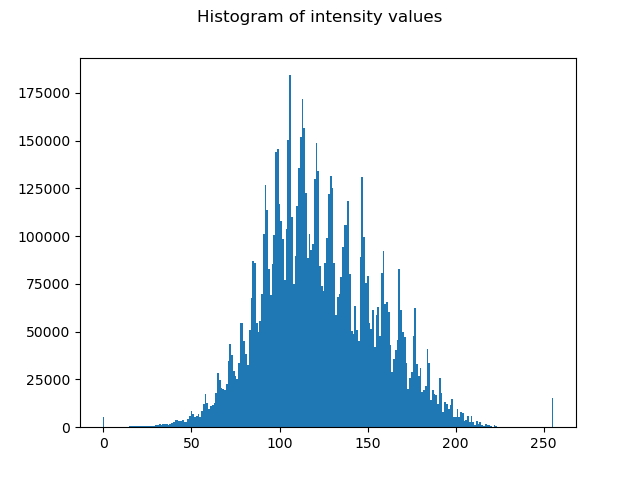

In [8]:
F, ax = plt.subplots()
F.suptitle("Histogram of intensity values")
ax.hist(img_array.ravel(), bins=256, range=(-0.5, 255.5));

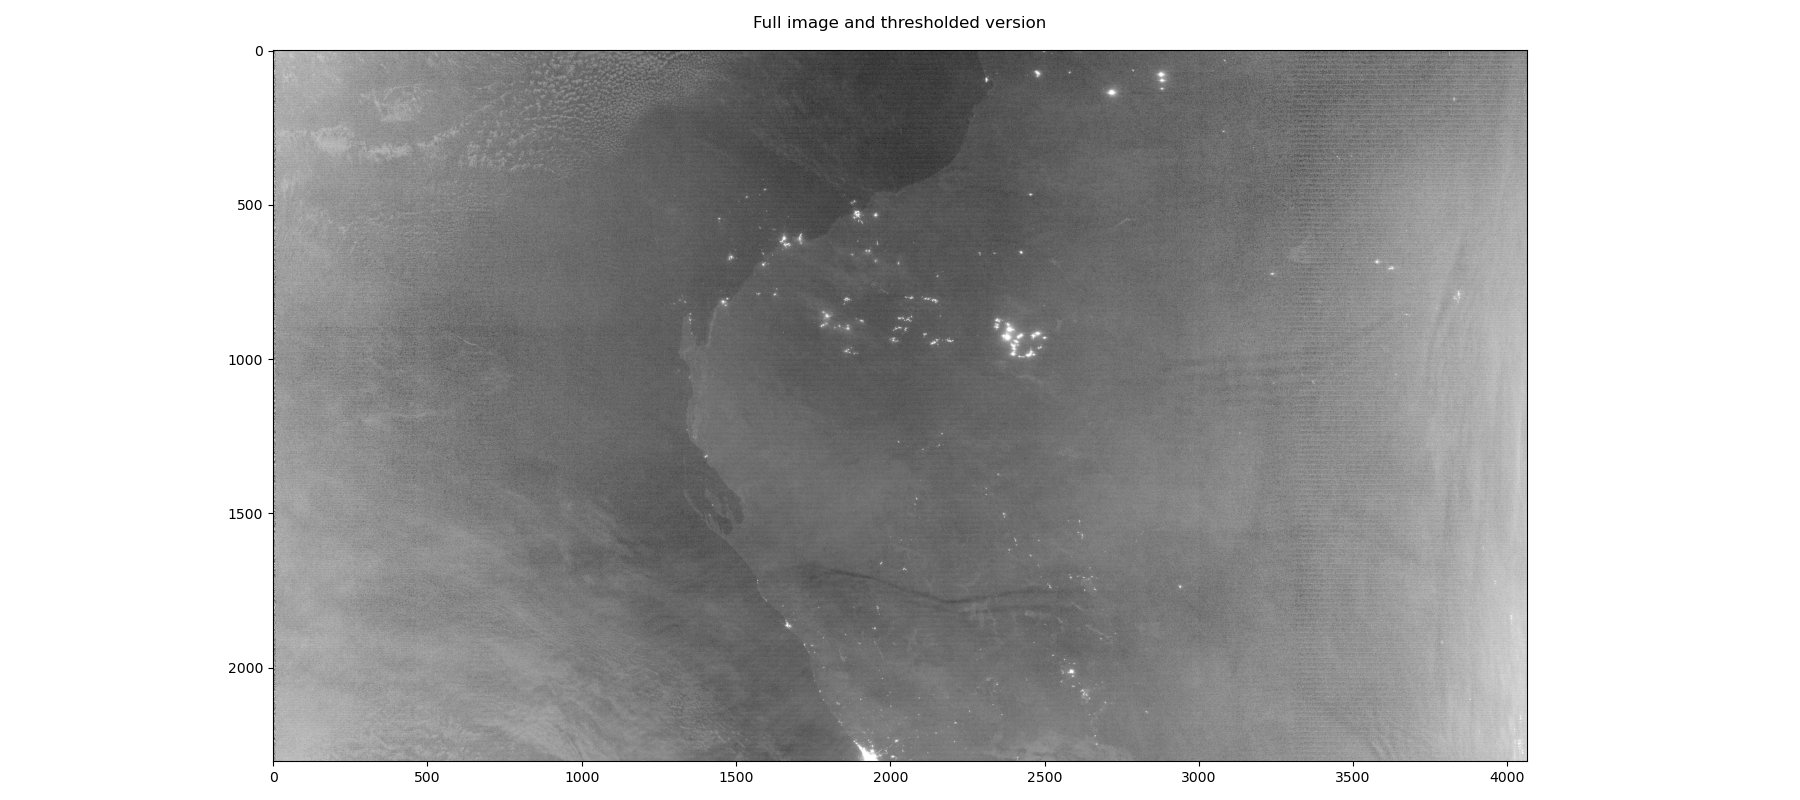

In [20]:
F, ax = plt.subplots(1, 1, figsize=(18, 8))
F.suptitle("Full image and thresholded version")
ax.imshow(img_array, cmap='gray', clim=(0, 255))
# ax.imshow(img_array_thresh, cmap='gray', clim=(0, 255))
F.tight_layout()

In [21]:
### sample_box_disp:
# args:
#    center_pt: center of the box
#    angle: angle of the line samples, in standard unit circle orientation
#    width: how wide the box is
#    sample_length: how long the box is
# returns:
#    box: a matplotlib patch that can be applied to an image
def sample_box_disp(center_pt, angle, width=50, sample_length=200):
    offset_vec = np.add((-sample_length/2*np.cos(angle), -sample_length/2*np.sin(angle)), (-width/2*np.cos(angle + np.pi/2), -width/2*np.sin(angle + np.pi/2)))
    corner = np.add(center_pt, offset_vec)
    box = mpl.patches.Rectangle(corner, width=sample_length, height=width, angle=np.degrees(angle), rotation_point='xy', fill=False, ec='red', lw=2)
    return box

In [22]:
sample_box = sample_box_disp(center, np.pi/2)
ax.add_patch(sample_box)

In [14]:
# Center based on median, as the bright regions likely bias the mean up
img_array_centered = np.subtract(img_array, np.median(img_array))

In [15]:
# sample_line: takes in a center point and an angle and returns evenly spaced coordinates along a line of the given length and angle. 
# The values start on the left for angles in the (-pi/2, pi/2) range.
# At sample_ratio = 1 and angle a multiple of pi/2, this will pull actual pixels with no interpolation.
# Returns a tuple (x_coords, y_coords) of coordinate lists.
def sample_line(center_pt, angle, length=200, sample_ratio=1):
    start = np.subtract(center_pt, (length/2 * np.cos(angle), length/2 * np.sin(angle)))
    end = np.add(center_pt, (length/2 * np.cos(angle), length/2 * np.sin(angle)))
    return np.linspace(start[0], end[0], sample_ratio*length + 1), np.linspace(start[1], end[1], sample_ratio*length + 1)

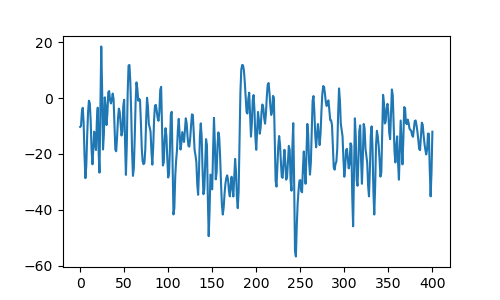

In [16]:
center = (2280, 1800)

x, y = sample_line(center, np.pi/2, sample_ratio=2)

vals = scipy.ndimage.map_coordinates(img_array_centered, np.vstack((y, x)))

F, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(vals)

In [ ]:
center = (2380, 1800)

x, y = sample_line(center, np.pi/2, sample_ratio=2)

vals = scipy.ndimage.map_coordinates(img_array_centered, np.vstack((y, x)))

F, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(vals)

In [65]:
# parallel_line_vals:
# args:
#    center_pt: center of the entire sample
#    angle: angle of the parallel sample lines
#    width: how wide the batch of parallel lines should be
#    sample_length: how many pixels long the sample lines should be
#    sample_ratio: how densely each sample line should be sampled
#    crop: whether to crop the image down to increase the speed of map_coordinates
# If crop is set, crops the image down to just the size needed for the lines (plus 20 pixels on each side for map_coordinate's interplation) to speed up computation significantly; the speed of map_coordinates seems to be sensitive to input size
# First finds a line of length given by width through the center point perpendicular to the parallel lines and computes center points (center_x, center_y) for the parallel lines
# The interpolated values from the ith line are stored in the ith row of the line_vals matrix
def parallel_line_vals(img, center_pt, angle, width=50, sample_length=200, sample_ratio=1, crop=True):
    if crop:
        radius = int(np.ceil(max(width/2, sample_length/2))) + 20
        start, end = (np.subtract(center_pt, radius), np.add(center_pt, radius))
        _img = img[start[1]:end[1], start[0]:end[0]]
        _center = np.subtract(center_pt, start)
    else:
        _img = img
        _center = center_pt
    center_x, center_y = sample_line(_center, angle + np.pi/2, width, 1)
    line_vals = np.empty((width + 1, sample_length*sample_ratio + 1))
    for i in tqdm(range(width + 1)):
        line_x, line_y = sample_line((center_x[i], center_y[i]), angle, sample_length, sample_ratio)
        line_vals[i, :] = scipy.ndimage.map_coordinates(_img, np.vstack((line_y, line_x)))
    return line_vals

In [33]:
radius = 100
start, end = (np.subtract(center, radius), np.add(center, radius))
img_crop = img_array_centered[start[1]:end[1], start[0]:end[0]]

In [37]:
np.subtract(center, start)

array([100, 100])

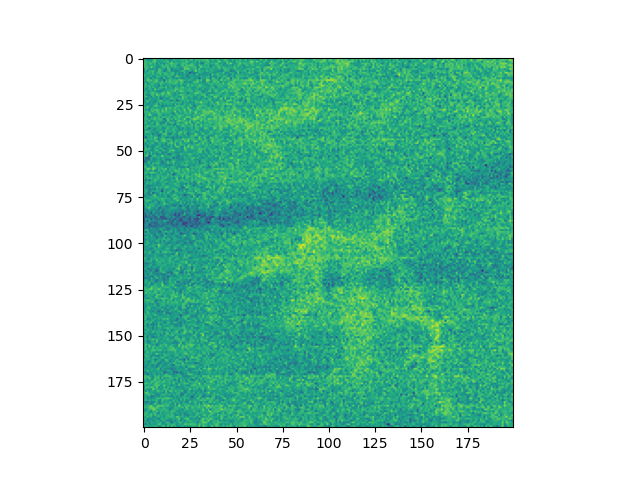

In [35]:
F, ax = plt.subplots(1, 1)
ax.imshow(img_crop)

In [62]:
A_crop = parallel_line_vals(img_array_centered, center, np.pi/2, sample_ratio=2)

  0%|          | 0/51 [00:00<?, ?it/s]

In [56]:
A_full = parallel_line_vals(img_array_centered, center, np.pi/2, sample_ratio=2, crop=False)

  0%|          | 0/51 [00:00<?, ?it/s]

In [64]:
np.subtract(A_crop, A_full).max()

5.0317083832851495e-11